# Project 2: Segmentation

In [1]:
%pylab inline
import guiseg
from sklearn.neighbors import KernelDensity
import cv2
import maxflow
import numpy as np
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Provided Images #################################################
banana = cv2.imread('provided_images/banana.png')[:,:,::-1]
b_fore, b_back = guiseg.get_fore_back(banana)
np.save("user_data/banana-fore", b_fore)
np.save("user_data/banana-back", b_back)
b_fore = tuple(np.load("user_data/banana-fore.npy"))
b_back = tuple(np.load("user_data/banana-back.npy"))


penguin = cv2.imread('provided_images/penguin.png')[:,:,::-1]
p_fore, p_back = guiseg.get_fore_back(penguin)
np.save("user_data/penguin-fore", p_fore)
np.save("user_data/penguin-back", p_back)
p_fore = tuple(np.load("user_data/penguin-fore.npy"))
p_back = tuple(np.load("user_data/penguin-back.npy"))


llama = cv2.imread('provided_images/llama.jpg')[:,:,::-1]
l_fore, l_back = guiseg.get_fore_back(llama)
np.save("user_data/llama-fore", l_fore)
np.save("user_data/llama-back", l_back)
l_fore = tuple(np.load("user_data/llama-fore.npy"))
l_back = tuple(np.load("user_data/llama-back.npy"))


teddy = cv2.imread('provided_images/teddy.png')[:,:,::-1]
t_fore, t_back = guiseg.get_fore_back(teddy)
np.save("user_data/teddy-fore", t_fore)
np.save("user_data/teddy-back", t_back)
t_fore = tuple(np.load("user_data/teddy-fore.npy"))
t_back = tuple(np.load("user_data/teddy-back.npy"))


In [3]:
# ## User Images ##################################################
hawk = cv2.imread('user_data/hawk.jpg')[:,:,::-1]
h_fore, h_back = guiseg.get_fore_back(hawk)
np.save("user_data/hawk-fore", h_fore)
np.save("user_data/hawk-back", h_back)
h_fore = tuple(np.load("user_data/hawk-fore.npy"))
h_back = tuple(np.load("user_data/hawk-back.npy"))


pancakes = cv2.imread('user_data/pancakes.jpg')[:,:,::-1]
pan_fore, pan_back = guiseg.get_fore_back(pancakes)
np.save("user_data/pancakes-fore", pan_fore)
np.save("user_data/pancakes-back", pan_back)
pan_fore = tuple(np.load("user_data/pancakes-fore.npy"))
pan_back = tuple(np.load("user_data/pancakes-back.npy"))


whale = cv2.imread('user_data/whale.jpg')[:,:,::-1]
w_fore, w_back = guiseg.get_fore_back(whale)
np.save("user_data/whale-fore", w_fore)
np.save("user_data/whale-back", w_back)
w_fore = tuple(np.load("user_data/whale-fore.npy"))
w_back = tuple(np.load("user_data/whale-back.npy"))

In [7]:
# Create the graph and nodes
def graph_cut(input, fore, back, sigma=8, bandwidth_=1.0, lambda_=1):
    # Create the graph ###################################################
    g = maxflow.Graph[int]()
    image = input.copy()
    dimensions = (image.shape[0], image.shape[1])
    nodeids = g.add_grid_nodes(dimensions)

    # Add the n-links (Boundary)##################################################################

    # get the left right edges
    A_image = image[:,:-1]     # left
    B_image = image[:,1:]      # right
    lr_diff = A_image - B_image
    lr_weights = [np.power(np.e, -np.linalg.norm(pixel)/(2*sigma**2)) for row in lr_diff for pixel in row]
    lr_weights = np.resize(np.array(lr_weights), dimensions)
    # get the top bottom edges
    C_image = image[:-1,:]    # top
    D_image = image[1:,:]     # bottom
    tb_diff = C_image - D_image

    tb_weights = [np.power(np.e, -np.linalg.norm(pixel)/(2*sigma**2)) for row in tb_diff for pixel in row]
    tb_weights = np.resize(np.array(tb_weights), dimensions)
    
    # add the n-links to the graph
    g.add_grid_edges(nodeids, lr_weights, structure=[[0,0,0],[0,0,1],[0,0,0]], symmetric=True)
    g.add_grid_edges(nodeids, tb_weights, structure=[[0,0,0],[0,0,0],[0,1,0]], symmetric=True)

    
    # Add the t-links ##################################################

    # Create the KDEs
    kde_source = KernelDensity(kernel='gaussian', bandwidth=bandwidth_).fit(image[fore])
    kde_sink = KernelDensity(kernel='gaussian', bandwidth=bandwidth_).fit(image[back])

    log_density_source = kde_source.score_samples(np.reshape(image, (image.shape[0]*image.shape[1], 3)))
    log_density_sink = kde_sink.score_samples(np.reshape(image, (image.shape[0]*image.shape[1], 3)))

    log_density_source = np.reshape(log_density_source, dimensions) * lambda_
    log_density_sink = np.reshape(log_density_sink, dimensions) * lambda_

    # add the terminal edges
    g.add_grid_tedges(nodeids, log_density_source, log_density_sink)

    # Get the final segments #######################################
    g.maxflow()

    final_segmentation = g.get_grid_segments(nodeids)
    final_segmentation = np.invert(final_segmentation)

    trimap = np.ones(dimensions) * 125
    trimap[fore] = 255
    trimap[back] = 0

    return final_segmentation, trimap

In [8]:
# banana Results ########################################
b_seg, b_trimap = graph_cut(banana, b_fore, b_back, sigma=12, bandwidth_=1.0)
b_ground_truth = cv2.imread('provided_images/ground_truth/banana-seg.png')

In [9]:
# penguin Results ########################################
p_seg, p_trimap = graph_cut(penguin, p_fore, p_back, sigma=12, bandwidth_=1.5, lambda_=0.5)
p_ground_truth = cv2.imread('provided_images/ground_truth/penguin-seg.png')

In [10]:
# llama Results ########################################
l_seg, l_trimap = graph_cut(llama, l_fore, l_back, sigma=12, bandwidth_=1.5)
l_ground_truth = cv2.imread('provided_images/ground_truth/llama-seg.png')

In [11]:
# teddy Results #######################################
t_seg, t_trimap = graph_cut(teddy, t_fore, t_back,sigma=12)
t_ground_truth = cv2.imread('provided_images/ground_truth/teddy-seg.png')

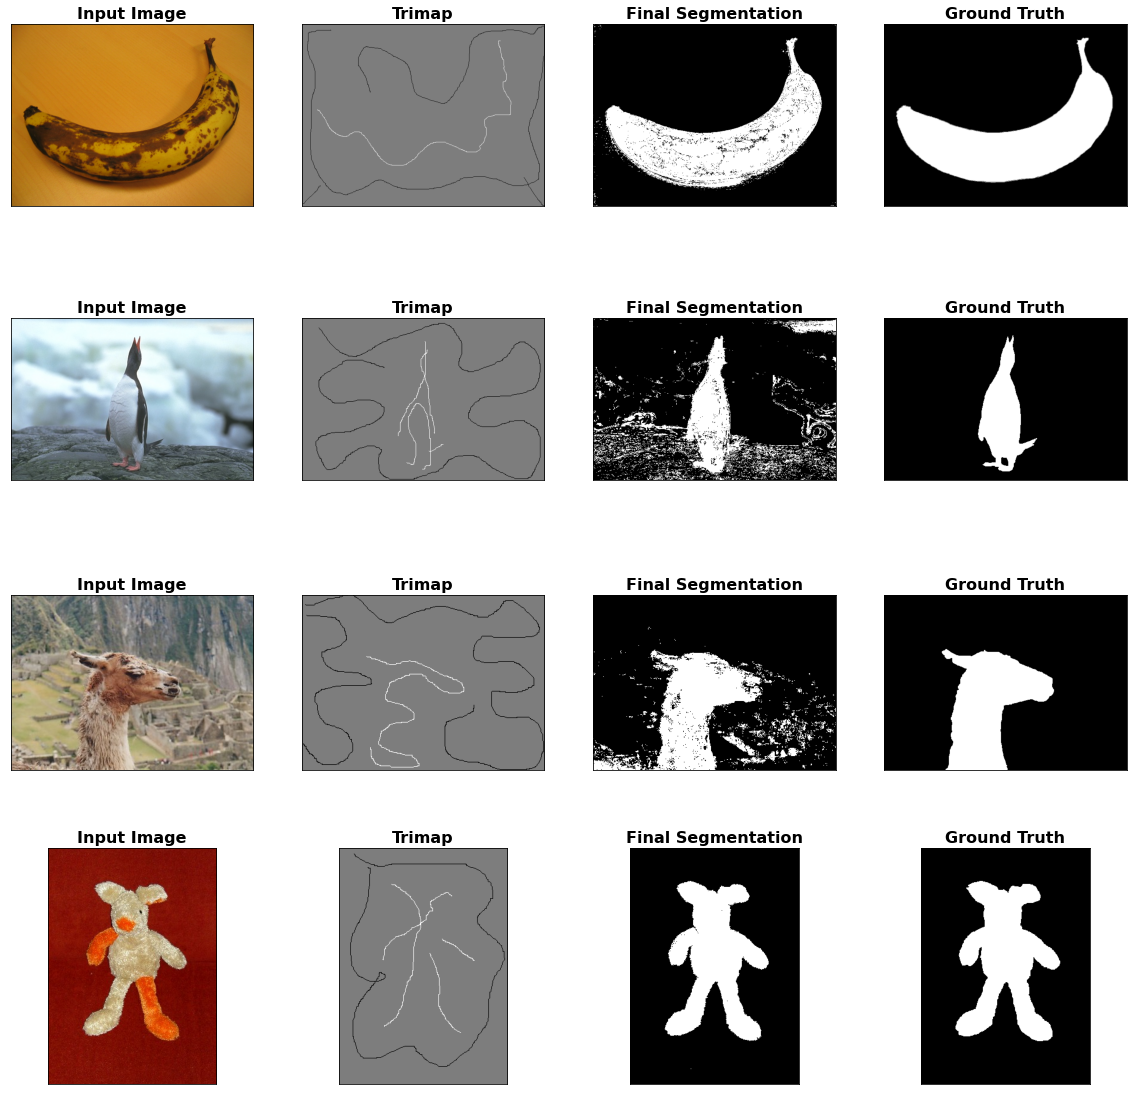

In [12]:
#banana ########################################
plt.subplot(441)
plt.imshow(banana)
just_title('Input Image')

plt.subplot(442)
plt.imshow(b_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(443)
plt.imshow(b_seg, cmap='gray')
just_title('Final Segmentation')

plt.subplot(444)
plt.imshow(b_ground_truth)
just_title('Ground Truth')

#penguin ########################################
plt.subplot(445)
plt.imshow(penguin)
just_title('Input Image')

plt.subplot(446)
plt.imshow(p_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(447)
plt.imshow(p_seg, cmap='gray')
just_title('Final Segmentation')

plt.subplot(448)
plt.imshow(p_ground_truth)
just_title('Ground Truth')


#llama ########################################
plt.subplot(449)
plt.imshow(llama)
just_title('Input Image')

plt.subplot(4,4,10)
plt.imshow(l_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(4,4,11)
plt.imshow(l_seg, cmap='gray')
just_title('Final Segmentation')

plt.subplot(4,4,12)
plt.imshow(l_ground_truth)
just_title('Ground Truth')

#teddy ########################################
plt.subplot(4,4,13)
plt.imshow(teddy)
just_title('Input Image')

plt.subplot(4,4,14)
plt.imshow(t_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(4,4,15)
plt.imshow(t_seg, cmap='gray')
just_title('Final Segmentation')

plt.subplot(4,4,16)
plt.imshow(t_ground_truth)
just_title('Ground Truth')

In [13]:
# hawk Results ########################################
h_seg, h_trimap = graph_cut(hawk, h_fore, h_back)

In [14]:
# whale Results ########################################
# Takes about 6 minutes
w_seg, w_trimap = graph_cut(whale, w_fore, w_back,sigma=14)

In [15]:
# pancakes Results ########################################
pan_seg, pan_trimap = graph_cut(pancakes, pan_fore, pan_back,sigma=11, bandwidth_=1.5)

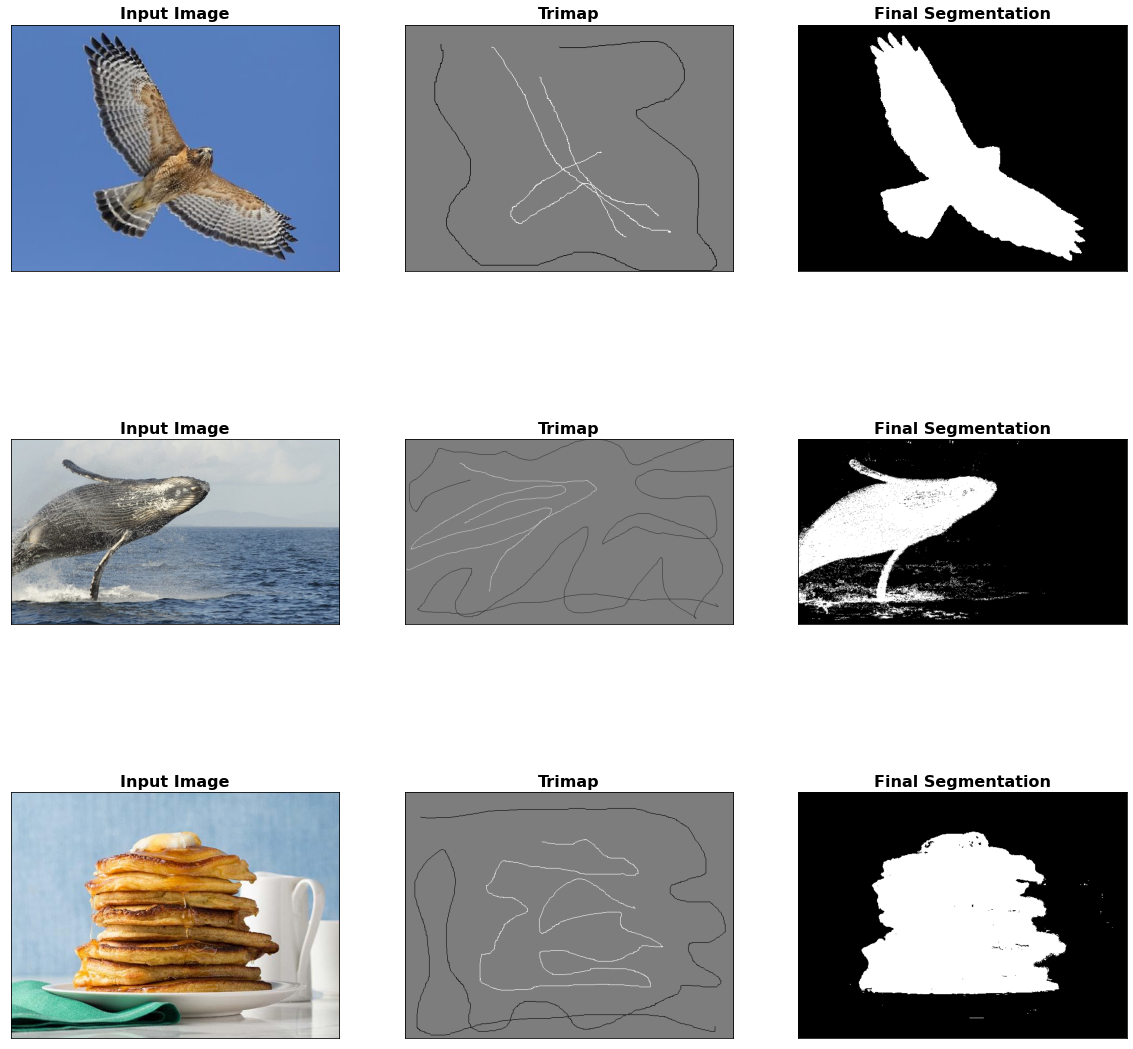

In [16]:
#hawk ########################################
plt.subplot(331)
plt.imshow(hawk)
just_title('Input Image')

plt.subplot(332)
plt.imshow(h_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(333)
plt.imshow(h_seg, cmap='gray')
just_title('Final Segmentation')

#whale ########################################
plt.subplot(334)
plt.imshow(whale)
just_title('Input Image')

plt.subplot(335)
plt.imshow(w_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(336)
plt.imshow(w_seg, cmap='gray')
just_title('Final Segmentation')

#llama ########################################
plt.subplot(337)
plt.imshow(pancakes)
just_title('Input Image')

plt.subplot(338)
plt.imshow(pan_trimap, cmap='gray')
just_title('Trimap')

plt.subplot(339)
plt.imshow(pan_seg, cmap='gray')
just_title('Final Segmentation')